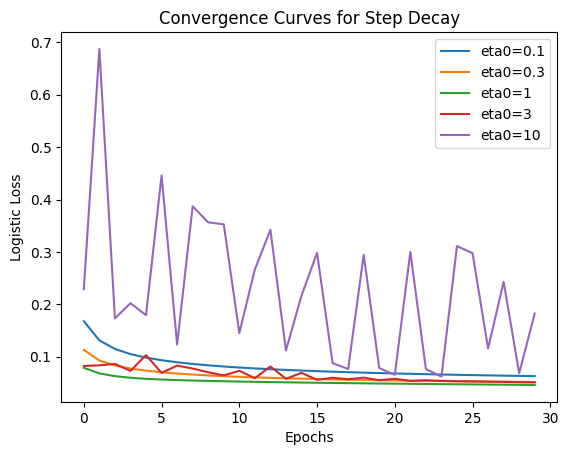

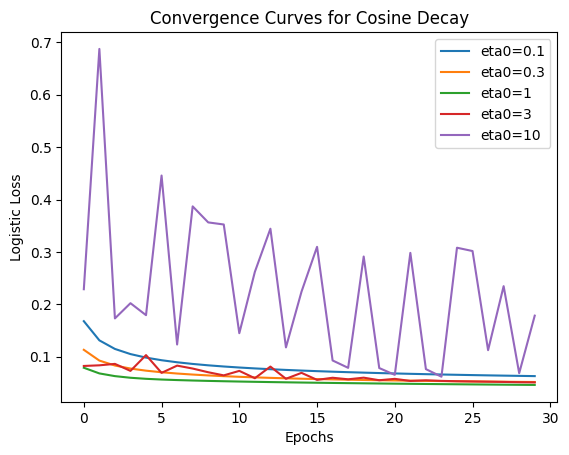

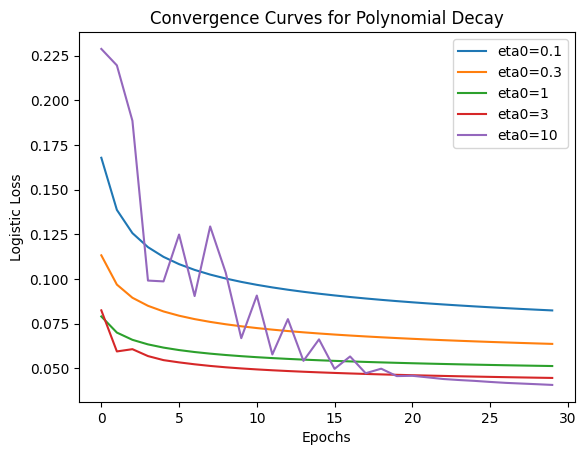

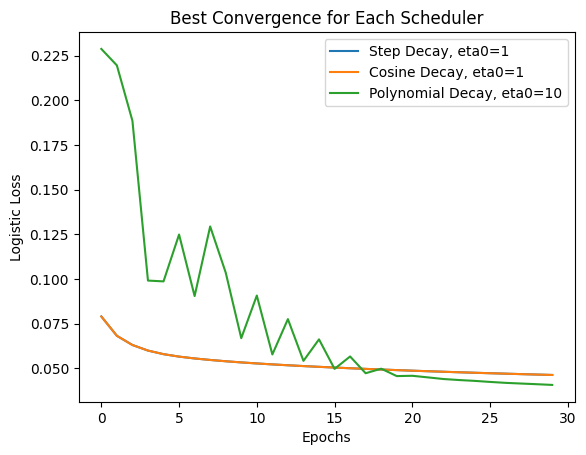

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load and preprocess dataset
data = load_breast_cancer()
X, y = data.data, data.target
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}
X = StandardScaler().fit_transform(X)  # Standardize features
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression objective function
def logistic_loss(w, X, y):
    return np.mean(np.log(1 + np.exp(-y * np.dot(X, w))))

# SGD with different learning rate schedulers
def sgd(X, y, epochs, batch_size, lr_scheduler, eta0, **kwargs):
    n, d = X.shape
    w = np.zeros(d)  # Initialize weights
    losses = []
    
    for epoch in range(epochs):
        for i in range(0, n, batch_size):
            Xi = X[i:i + batch_size]
            yi = y[i:i + batch_size]
            grad = -np.dot(yi * np.exp(-yi * np.dot(Xi, w)) / (1 + np.exp(-yi * np.dot(Xi, w))), Xi)
            eta = lr_scheduler(epoch+1, eta0, **kwargs)
            w -= eta * grad / batch_size
        losses.append(logistic_loss(w, X, y))
    
    return w, losses


# Hyperparameters
epochs = 30
batch_size = 16
initial_lrs = [0.1, 0.3, 1, 3, 10]     # Initial learning rate (can be tuned)
eta_min = 0.001  # Minimum learning rate
iterations_per_epoch = np.ceil(len(train_X) / batch_size)
t0 = 15 * iterations_per_epoch  # Learning rate decays every 15 epochs
alpha = 0.5      # Decay exponent
gamma = 0.1
T = epochs * iterations_per_epoch #total number of iterations

# Step decay scheduler
def step_decay(t, eta0, gamma=0.1, t0=t0):
    return eta0 * gamma ** (t // t0)

# Cosine decay scheduler
def cosine_decay(t, eta0, eta_min=0.001, T=T):
    return eta_min + 0.5 * (eta0 - eta_min) * (1 + np.cos(t * np.pi / T))

# Polynomial decay scheduler
def polynomial_decay(t, eta0, alpha=0.5):
    return eta0 / (t ** alpha)



# Running SGD for different schedulers
schedulers = {'Step Decay': step_decay, 'Cosine Decay': cosine_decay, 'Polynomial Decay': polynomial_decay}
results = {}

for name, scheduler in schedulers.items():
    for eta0 in initial_lrs:
        _, losses = sgd(train_X, train_y, epochs, batch_size, scheduler, eta0)
        results[(name, eta0)] = losses

# Plot convergence curves for each scheduler and learning rate
for name, scheduler in schedulers.items():
    plt.figure()
    for eta0 in initial_lrs:
        plt.plot(results[(name, eta0)], label=f'eta0={eta0}')
    plt.title(f'Convergence Curves for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Logistic Loss')
    plt.legend()
    plt.show()

# Compare the best convergence curves for each scheduler
plt.figure()
for name in schedulers.keys():
    best_eta0 = min(initial_lrs, key=lambda lr: results[(name, lr)][-1])
    plt.plot(results[(name, best_eta0)], label=f'{name}, eta0={best_eta0}')
plt.title('Best Convergence for Each Scheduler')
plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.legend()
plt.show()
